In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Prepare training and validation datasets

In [5]:
batch_size = 32
img_height = 180
img_width = 180

directory = "/home/atti/Documents/PV162_CV/IMAGES/Coins/Euro/"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

class_names = train_ds.class_names
print("Class names: " + str(class_names))

Found 237 files belonging to 4 classes.
Using 190 files for training.
Found 237 files belonging to 4 classes.
Using 47 files for validation.
Class names: ['brass', 'copper', 'euro1', 'euro2']


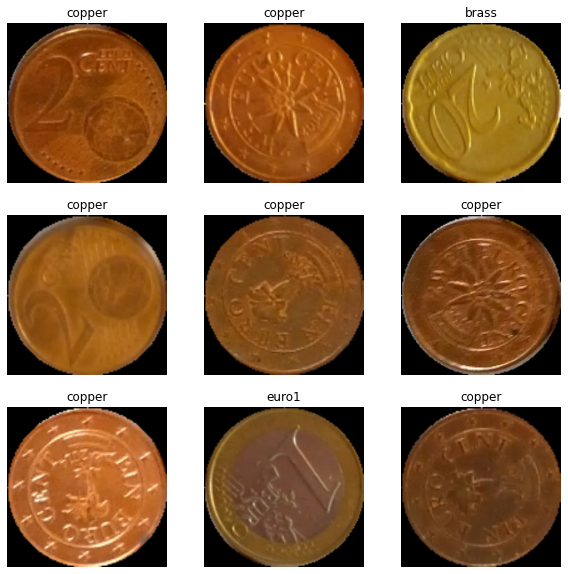

In [17]:
images, labels = next(iter(train_ds.skip(3).take(1)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Optimize for performance

`Dataset.cache()` - to keep the images in memory after they're loaded off disk during the first epoch

`Dataset.prefetch()` - overlaps data preprocessing and model execution while training

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalize the dataset

`[0, 255] -> [0, 1]`

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

## Create the model

In [34]:
num_classes = len(class_names)

model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30976)            

## Train the model

In [38]:
epochs=20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
6/6 [==============================] - 1s 246ms/step - loss: 0.3539 - accuracy: 0.8526 - val_loss: 11.4619 - val_accuracy: 0.9149
Epoch 2/20
6/6 [==============================] - 1s 248ms/step - loss: 0.2654 - accuracy: 0.8947 - val_loss: 30.9462 - val_accuracy: 0.9362
Epoch 3/20
6/6 [==============================] - 2s 255ms/step - loss: 0.1915 - accuracy: 0.9368 - val_loss: 0.8394 - val_accuracy: 0.9574
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 0.1311 - accuracy: 0.9737 - val_loss: 3.7170 - val_accuracy: 0.9574
Epoch 5/20
6/6 [==============================] - 1s 246ms/step - loss: 0.0995 - accuracy: 0.9842 - val_loss: 14.7755 - val_accuracy: 0.9362
Epoch 6/20
6/6 [==============================] - 2s 255ms/step - loss: 0.2991 - accuracy: 0.8947 - val_loss: 21.8062 - val_accuracy: 0.9362
Epoch 7/20
6/6 [==============================] - 2s 253ms/step - loss: 0.4054 - accuracy: 0.8474 - val_loss: 101.6938 - val_accuracy: 0.9574
Epoch 8/20
6/6

## Visualize training results

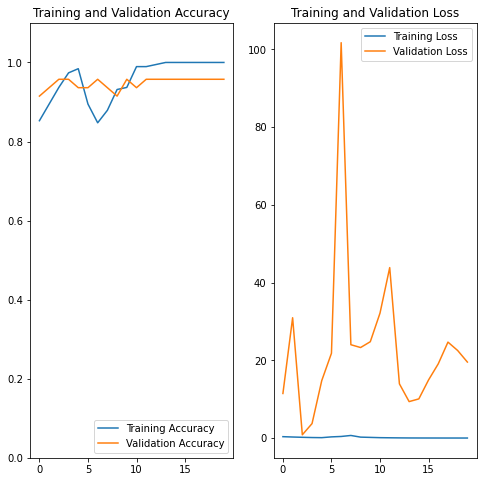

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0,1.1])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Predicted: copper with a 100.00% confidence.
Correct: copper


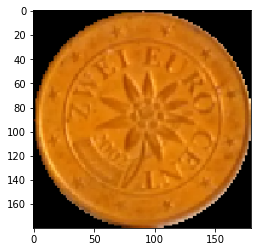

In [76]:
import random

class_num = 1

img_dir_path = directory + str(class_names[class_num])
img_dir = os.listdir(img_dir_path)
img_name = img_dir[random.randint(0, len(img_dir)-1)]
img_path = img_dir_path + "/" + img_name

img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(tf.keras.preprocessing.image.img_to_array(img)/255.)

print(
    "Predicted: {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print("Correct: " + str(class_names[class_num]))